In [1]:
import itertools
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd

import json
import functools
from glob import glob
import os

from importlib import reload

import utils
import persim

import tifffile as tf
from KDEpy import FFTKDE
from scipy import ndimage,stats,spatial
from sklearn import decomposition, preprocessing

In [2]:
nuclei_mask_cutoff = 1
seed = 42
ndims = 3
fs = 12
PP = 6
dpi = 96
minlife = 0.0
rng = np.random.default_rng(seed)
permmethod = stats.PermutationMethod(n_resamples=999, random_state=rng)

Cmap='plasma'
pxs = 75
pxbar = np.s_[-25:-5, 5:5 + pxs]
s = 50
alphaNmin = 0.1
alphaNmax = 10

wong = ['#d81b60', '#b5b5b5', '#6b6b6b', '#000000']
marker = ['D', '8', 's', '^', 'v', 'P', 'X', '*']
color = ['#56b4e9', '#f0e442', '#009e73', '#0072b2', '#d55e00', '#cc79a7', '#e69f00', '#e0e0e0', '#000000']
cmap = ['Blues_r', 'RdPu_r', 'Greens_r', 'BuPu_r', 'Oranges_r', 'Wistia', 'YlOrBr_r', 'gray', 'gist_gray']
box_params = {'widths':0.75, 'patch_artist':True, 'medianprops':{'lw':3, 'color':'red'} }
#figdst = os.path.expanduser('~') + '/documents/website/mcarto/figs/'
sample = 'D2'

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
ksrc = '../kde/'
isrc = '..' + os.sep + 'infected_focus_summer24' + os.sep 

isrc += sample + os.sep
ksrc += sample + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col='ndimage_cellID')
metaecc = pd.read_csv(ksrc + sample + '_nodule_root_eccentricity.csv', index_col='ndimage_cellID')
metaecc['eccentricity'] = metaecc['eccentricity'].max() - metaecc['eccentricity'].values

metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv').set_index('gene')
cell_nuc = pd.read_csv(ksrc + sample + '_nuclei_limits.csv')
transcriptomes = np.asarray(list(metatrans['gene']))
metatrans = metatrans.set_index('gene')

Cells = utils.get_range_cell_values(isrc + 'infected_cells_ids.csv', metacell, startval=1)
Cells = np.setdiff1d( Cells, metacell[metacell['number_nuclei'] > 1].index)

Genes = utils.get_range_gene_values(isrc + 'genes_to_focus_infection.csv', transcriptomes, startval=0)
Cs = dict(zip(Genes, ['#56b4e9','#cc79a7']))
Ms = dict(zip(Genes, ['D','s']))
Ps = dict(zip(Genes, ['Blues_r','PuRd_r']))
invGenes = dict(zip(Genes, range(len(Genes))))
invCells = dict(zip(Cells, range(len(Cells))))
transfocus = transcell.loc[transcriptomes[Genes], Cells.astype(str)]

wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))
print('Detected',cellnum,'cells')

lnuc, nnuc = ndimage.label(tf.imread(nsrc + sample + '_EDT.tif') < nuclei_mask_cutoff, ndimage.generate_binary_structure(2,1))
print('Detected',nnuc,'nuclei')
wcoords = np.asarray(np.nonzero(~wall))
foo = [ wong[-1], wong[-2] ] + np.repeat(wong[1], nnuc).tolist() + ['#f0f0f0']
cellular_cmap = ListedColormap(foo)

wc = wcoords[:, ~np.all(wcoords%100, axis=0)]

translocs = [None for i in range(len(transcriptomes))]
for i in range(len(transcriptomes)):
    filename = tsrc + sample + os.sep + 'location_corrected_D2_-_' + transcriptomes[i] + '.csv'
    translocs[i] = pd.read_csv(filename, header=None, names=['X', 'Y', 'Z'])
tlocs = pd.concat(translocs)
tcumsum = np.hstack(([0], np.cumsum(metatrans['cyto_number'].values)))

handles = [None for _ in range(len(Genes))]
for i in range(len(handles)):
    handles[i] = mlines.Line2D([], [], mfc=color[i], marker=marker[i], ls='None', mec='k', mew=1, ms=7)

N_nuclear = np.zeros((len(metacell), len(Genes)), dtype=int)
for i,gidx in enumerate(Genes):
    rawlocs = pd.read_csv('../Bacteria Info for Erik/'+transcriptomes[gidx]+'.txt', sep='\t')
    rawlocs = rawlocs[rawlocs['L'] == 'n']
    N_nuclear[:,i], _ = np.histogram( label[rawlocs['Y'], rawlocs['X']], bins=range(1,cellnum+2))

N_nuclear = pd.DataFrame(N_nuclear, columns=['N_nuclear_'+g for g in transcriptomes[Genes]], index=metacell.index)
rho_nuclear = pd.DataFrame(index=metacell.index)
for gidx in Genes:
    rho_nuclear['rho_nuclear_'+transcriptomes[gidx]] = N_nuclear['N_nuclear_'+transcriptomes[gidx]]/metacell['nuclei_area'].values
rho_nuclear = rho_nuclear.replace(np.nan, 0)
N_nuclear = N_nuclear.join(rho_nuclear).iloc[:, [0,2,1,3]]

Detected 2937 cells
Detected 1365 nuclei


# Bring in persistence images to the party

In [3]:
level = 'sub'
normtype = 'both'
stepsize = 3
bw = 25
SCALE = 32

zmax = np.max(tlocs['Z']+stepsize)
zbins = np.arange(0, zmax+stepsize, stepsize)

dsrc = isrc + 'G{}_{}level_{}_step{}_bw{}'.format(len(Genes), level, normtype, stepsize, bw) + os.sep
ratios = utils.normalize_counts(transfocus, normtype)

jsonfiles = [ [ None for j in range(ratios.shape[1]) ] for i in range(ratios.shape[0]) ]
gsrc = '../{}level/'.format(level) + sample + os.sep
for i in range(len(jsonfiles)):
    foo = '{}{}/{}_-_{}_p{}_s{}_bw{}_c{:06d}.json'
    for j in range(len(jsonfiles[0])):
        filename = foo.format(gsrc, transcriptomes[Genes[i]],transcriptomes[Genes[i]],level,PP,stepsize,bw,Cells[j])
        if os.path.isfile(filename):
            jsonfiles[i][j] = filename

orig_diags = [ utils.get_diagrams(jsonfiles[i], ndims, remove_inf=True) for i in range(len(jsonfiles))]
orig_diags, rescale, maxlife, focus_dim = utils.normalize_persistence_diagrams(orig_diags, ratios, normtype, SCALE)

kde_max = np.zeros(ratios.size)
for i in range(len(orig_diags)):
    for j in range(len(orig_diags[i])):
        if len(orig_diags[i][j][focus_dim]) > 0:
            kde_max[i*len(orig_diags[i]) + j] = np.max(orig_diags[i][j][focus_dim])

kmax = np.sort(kde_max)[-20]

lt_mask = np.any(maxlife > minlife, axis=2)
gmask, cmask = np.nonzero(lt_mask)
bsummary = pd.DataFrame()
bsummary['gene_ID'] = Genes[gmask]
bsummary['ndimage_ID'] = Cells[cmask]
uq , cts = np.unique(gmask, return_counts=True)
nzcumsum = np.hstack(([0], np.cumsum(cts) ))

if normtype == 'gene':
    diags = [ [ [ rescale[i][0][0]*orig_diags[i][j][k].copy() for k in range(len(orig_diags[i][j])) ] for j in range(len(orig_diags[i])) ] for i in range(len(orig_diags)) ]
elif normtype == 'both':
    diags = [ [ [ rescale*orig_diags[i][j][k].copy() for k in range(len(orig_diags[i][j])) ] for j in range(len(orig_diags[i])) ] for i in range(len(orig_diags)) ]
for i in range(len(diags)):
    for j in range(len(diags[i])):
        for k in range(len(diags[i][j])):
            diags[i][j][k] = np.atleast_2d(diags[i][j][k][ diags[i][j][k][:,1] - diags[i][j][k][:,0] > minlife, : ])

full_lt_coll = [ [None for _ in range(np.sum(lt_mask)) ] for _ in range(ndims) ]
for i in range(len(gmask)):
    for k in range(len(full_lt_coll)):
        d = diags[gmask[i]][cmask[i]][k]
        full_lt_coll[k][i] = np.column_stack( (d[:, 0], d[:, 1] - d[:, 0])  )

maxbirth = 0
for k in range(len(full_lt_coll)):
    for i in range(len(full_lt_coll[k])):
        if len(full_lt_coll[k][i]) > 0:
            b = np.max(full_lt_coll[k][i][:,0])
            if b > maxbirth:
                maxbirth = b

Initial number of life-birth pairs	: 69430

No. of diagrams s.t. H_k had the most persistent component
H_0:	56 [ 3.1% ]
H_1:	137 [ 7.5% ]
H_2:	1643 [ 89.5% ]

Will focus just on dimension k = 2



# Loadings

In [5]:
cidx = metacell[metacell['orig_cellID'] == 1088].index[0]
cidx = 1088
reps = []
for cidx in [1088, 1203, 1612, 447]:
    reps.append(embedding[embedding['ndimage_ID'] == cidx].index.values)
reps = np.hstack(reps)
reps

array([ 376, 1294,  435, 1353,  628, 1546,   70,  988])

In [98]:
gidx = 26
cidx = 169

cmask = label[ translocs[gidx]['Y'], translocs[gidx]['X'] ] == cidx
coords = translocs[gidx].iloc[cmask].values.T
cell, cextent = utils.get_cell_img(cidx, metacell, label, lnuc, nnuc, pxbar=True)
edt = ndimage.distance_transform_edt(cell > 0)

axes, grid, kdegmask, cgrid, outside_walls = utils.cell_grid_preparation(cidx, cell, cextent, zmax, stepsize, cell_nuc)

kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(coords.T).evaluate(grid)
kde = kde[kdegmask]/(np.sum(kde[kdegmask])*(stepsize**len(coords)))
kde[outside_walls] = 0
kde = kde/(np.sum(kde)*(stepsize**len(coords)))
kde = kde.reshape( list(map(len, axes))[::-1], order='F')
   
hkde = kde.copy() * ratios[invGenes[gidx]][invCells[cidx]]

In [99]:
kbins = np.linspace(0, np.max(edt), 7)
cellhist = np.zeros_like(cell)
for i in range(len(kbins)-1):
    cellhist[ (edt > kbins[i]) & (edt <= kbins[i+1]) ] = i + 1

In [100]:
kdehist = np.zeros(hkde.shape, dtype=int)

In [101]:
zoom = ndimage.zoom(cellhist, 1/stepsize, mode='grid-constant', grid_mode=True)

In [102]:
print(hkde.shape, zoom.shape)

(22, 141, 168) (140, 168)


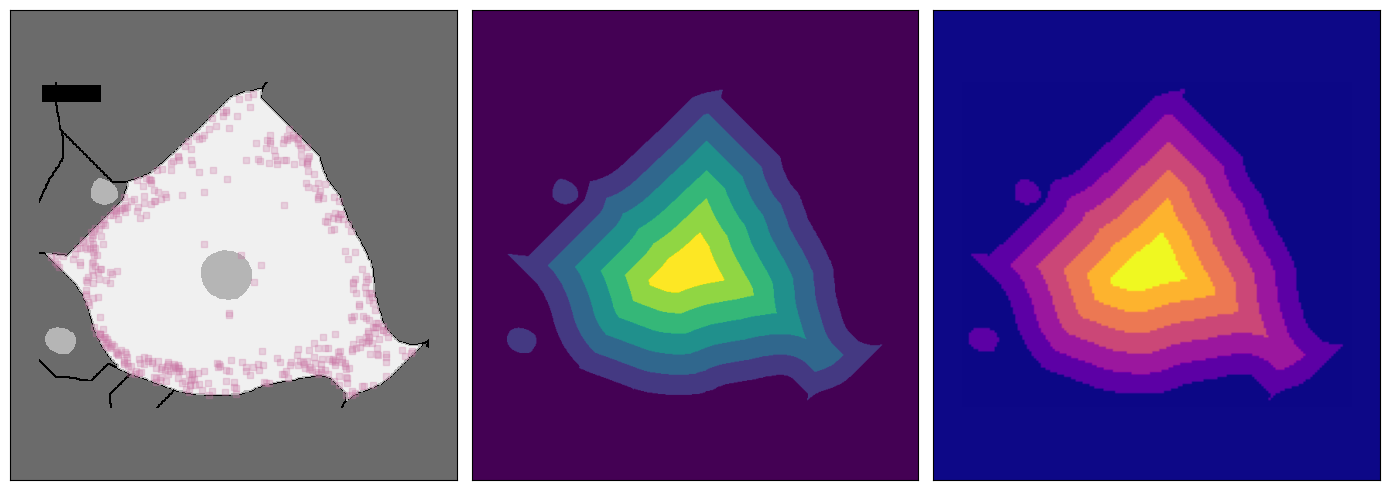

In [103]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

alpha = min([1.5*int(4e6/cell.size)/100, 1])
ax[i].imshow(cell+1, cmap=cellular_cmap, origin='lower', extent=cextent, vmin=0, vmax=nnuc+2);
ax[i].scatter(*coords[:2], color=Cs[gidx], marker=Ms[gidx], alpha=alpha, s=int(4e6/cell.size))
ax[i].set_facecolor(wong[2])

i += 1
ax[i].imshow(cellhist, vmin=0, origin='lower', extent=cextent)
ax[i].set_facecolor(mpl.colormaps['viridis'](0))

i += 1
ax[i].imshow(zoom, origin='lower', cmap=Cmap, vmin=0)#, vmax=kmax, zorder=1)
ax[i].set_facecolor( mpl.colormaps[ Cmap ](0) )

for i in range(len(ax)):
    ax[i].set_aspect('equal','datalim')
    ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    ax[i].set_aspect('equal','datalim')

fig.tight_layout()

In [78]:
np.ceil(np.hstack( ([zmax],cell.shape)) /stepsize).astype(int)

array([ 22, 118, 144])

In [76]:
hkde.shape

(22, 118, 144)

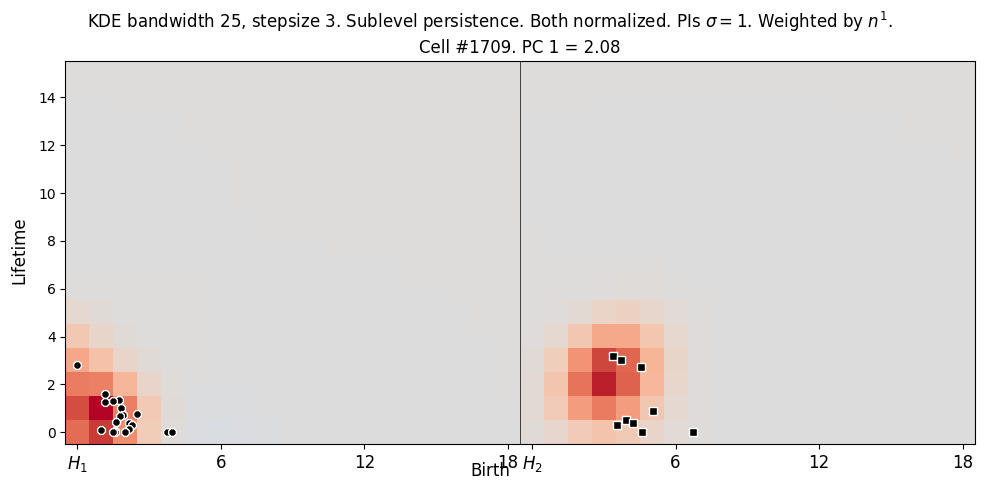

In [270]:
pcacol = 3
pcarow = np.where(pca.shape[1] % pcacol == 0, pca.shape[1]//pcacol, pca.shape[1]//pcacol + 1) + 0

xlabs = np.tile(np.arange(0, full_img.shape[2], full_img.shape[2]//3), len(hdims))
xticks = np.hstack([ np.arange(0, full_img.shape[2], xlabs[1]-xlabs[0]) + i*full_img.shape[2] for i in range(len(hdims)) ])
xlabs = xlabs.astype(str)
xlabs[xlabs == '0'] = [ '$H_{}$'.format(hdims[i]) for i in range(len(hdims)) ]

fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0
for i in range(len(ax)):
    ll = loadings[:,i].reshape( len(hdims)*full_img.shape[2], full_img.shape[3], order='C').T
    vmax = np.max(np.abs(ll))
    ax[i].imshow(ll, cmap='coolwarm', vmax=vmax, vmin=-vmax, origin='lower')
    ax[i].set_title('Cell #{}. PC 1 = {:.2f}'.format(int(embedding.loc[ix].iloc[1]), embedding.loc[ix].iloc[2]), fontsize=fs)
    for hdim in hdims:
        d = full_lt_coll[hdim][ix]
        x = (hdim-1)*full_img.shape[2]
        ax[i].scatter(x+d[:,0], d[:,1], label='$H_{}$'.format(hdim), marker=marker[hdim], c='k', linewidth=1, edgecolor='w')
    for j in range(1, len(hdims)):
        ax[i].axvline(j*full_img.shape[2] - .5, c='k', lw=0.5)
    ax[i].set_xticks(xticks, xlabs, fontsize=fs)

for i in range(loadings.shape[1], len(ax)):
    fig.delaxes(ax[i])
fig.supxlabel('Birth', y=.04, fontsize=fs); 
fig.supylabel('Lifetime', fontsize=fs)
fig.suptitle(Bname, fontsize=fs)
fig.tight_layout();
plt.savefig('cell1709_persistence_image_loading.png', dpi=dpi, bbox_inches='tight', format='png')

'../translocs/D2/location_corrected_D2_-_GLYMA_20G151700.csv'

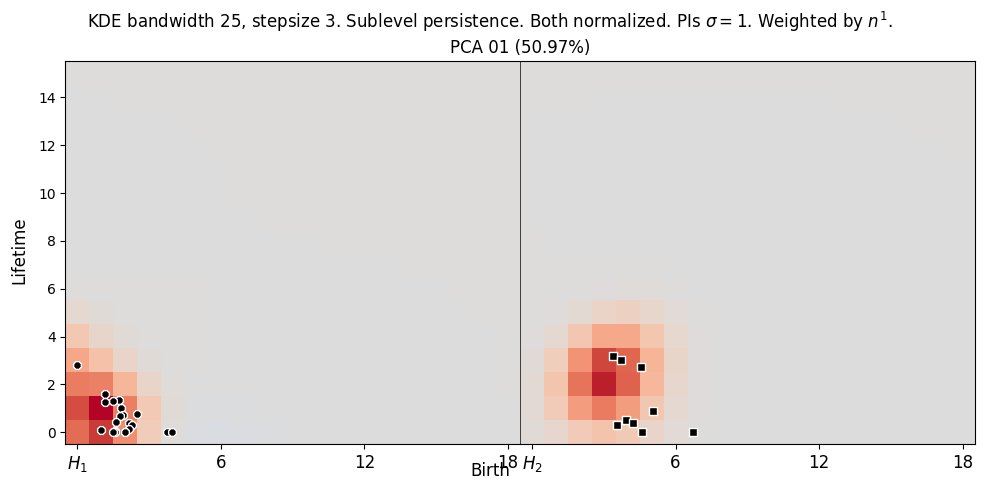

In [254]:
pcacol = 3
pcarow = np.where(pca.shape[1] % pcacol == 0, pca.shape[1]//pcacol, pca.shape[1]//pcacol + 1) + 0

xlabs = np.tile(np.arange(0, full_img.shape[2], full_img.shape[2]//3), len(hdims))
xticks = np.hstack([ np.arange(0, full_img.shape[2], xlabs[1]-xlabs[0]) + i*full_img.shape[2] for i in range(len(hdims)) ])
xlabs = xlabs.astype(str)
xlabs[xlabs == '0'] = [ '$H_{}$'.format(hdims[i]) for i in range(len(hdims)) ]

fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0
for i in range(len(ax)):
    ll = loadings[:,i].reshape( len(hdims)*full_img.shape[2], full_img.shape[3], order='C').T
    vmax = np.max(np.abs(ll))
    ax[i].imshow(ll, cmap='coolwarm', vmax=vmax, vmin=-vmax, origin='lower')
    ax[i].set_title('{} {:02d} ({:.2f}%)'.format(method, i+1, explained_ratio[i]), fontsize=fs)
    for hdim in hdims:
        d = full_lt_coll[hdim][ix]
        x = (hdim-1)*full_img.shape[2]
        ax[i].scatter(x+d[:,0], d[:,1], label='$H_{}$'.format(hdim), marker=marker[hdim], c='k', linewidth=1, edgecolor='w')
    for j in range(1, len(hdims)):
        ax[i].axvline(j*full_img.shape[2] - .5, c='k', lw=0.5)
    ax[i].set_xticks(xticks, xlabs, fontsize=fs)
for i in range(loadings.shape[1], len(ax)):
    fig.delaxes(ax[i])
fig.supxlabel('Birth', y=.04, fontsize=fs); 
fig.supylabel('Lifetime', fontsize=fs)
fig.suptitle(Bname, fontsize=fs)
fig.tight_layout();
#plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

[50.96942546 21.2612809   7.07030284  5.82652166  3.18591494  2.18331799]
Total explained var:	 90.49676379184916 72.23070636161081


In [49]:
for k in range(len(reps)):
    for j in range(len(hdims)):
        fig, ax = plt.subplots(1,1, figsize=(5,5), sharex=True, sharey=True)
        ax = np.atleast_1d(ax).ravel(); i = 0
        ax[i].imshow(img[hdims[j],k].T, cmap=cmap[2+hdims[j]], vmin=0, vmax=pimax, origin='lower')
        ax[i].text((extent[1]-extent[0])*.95, (extent[3]-extent[2])*.95, 
                   '$H_{}$'.format(hdims[j]), color='w', ha='right', va='top', fontsize=1.5*fs)
        ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
        plt.subplots_adjust(wspace=0, hspace=0);
        foo = nameparams + [hdims[j], metacell.loc[embedding.loc[reps[k], 'ndimage_ID'], 'orig_cellID'], transcriptomes[embedding.loc[reps[k], 'gene_ID']] ]
        filename = dst + '{}level_{}_s{}_bw{}_S{}_{}_{}_{}_pi{}_c{}_{}'.format(*foo)
        print(filename)
        fig.savefig(filename + '.pdf', bbox_inches='tight',transparent=False, pad_inches=0);
        plt.close()

/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pi1_c2530_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pi2_c2530_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pi1_c2530_GLYMA_05G092200
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pi2_c2530_GLYMA_05G092200
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pi1_c613_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pi2_c613_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pi1_c613_GLYMA_05G092200
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pi2_c613_GLYMA_05G092200
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pi1_c1544_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pi2_c1544_GLYMA_17G195900
/hom

# Linking to eccenctricity

In [28]:
metacell

,x0,x1,y0,y1,length,height,total_area,nuclei_area,cyto_area,c2t_area_ratio,nuclei_volume,cyto_volume,total_volume,number_nuclei,orig_comX,orig_comY,ndimage_comX,ndimage_comY,orig_cellID
ndimage_cellID,,,,,,,,,,,,,,,,,,,
1,0,17152,0,17152,17152,17152,114911591,36950,114874641,0.999678,1514950,4709860281,4711375231,0,7865.12,8160.49,7865.56,8160.76,1
2,8333,8935,1293,1979,602,686,222903,1351,221552,0.993939,55391,9083632,9139023,1,8635.46,1576.65,8635.18,1577.03,2
3,8893,9151,1317,1598,258,281,42604,0,42604,1.000000,0,1746764,1746764,0,9013.47,1470.26,9013.07,1469.69,3
4,10790,11221,1337,1591,431,254,77463,0,77463,1.000000,0,3175983,3175983,0,10999.04,1460.48,10998.62,1459.99,4
5,7740,8048,1362,1823,308,461,86041,870,85171,0.989889,35670,3492011,3527681,1,7894.78,1596.06,7894.19,1595.83,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,3828,4249,16197,16436,421,239,61860,0,61860,1.000000,0,2536260,2536260,0,4051.30,16319.91,4050.78,16319.31,2934
2934,4085,4567,16241,16650,482,409,127384,0,127384,1.000000,0,5222744,5222744,0,4338.51,16440.70,4337.88,16440.30,2935
2935,5199,5496,16267,16456,297,189,27989,0,27989,1.000000,0,1147549,1147549,0,5336.04,16367.01,5335.80,16366.57,2936


In [31]:
perc_inside = cell_nuc.loc[cell_nuc['perc_inside'] > 0.5, 'ndimage_ID'].unique()
number_nuclei = metacell[metacell['number_nuclei'] < 2].index.values
w_nuclei = np.intersect1d(Cells, np.intersect1d(perc_inside, number_nuclei))

cell_mask = 'all'
# cell_mask = 'nuc'
print(cell_mask)

bar = pd.DataFrame(index=Cells)
for i in range(len(Genes)):
    foo = embedding.loc[embedding['gene_ID'] == Genes[i], np.hstack((['ndimage_ID'], embedding.columns[2:4])) ].set_index('ndimage_ID')
    foo.columns = [ x.split(' (')[0]+'_'+transcriptomes[Genes[i]]  for x in foo.columns.values ]
    bar = bar.join(foo)
for gidx in Genes:
    foo = transcell.loc[transcriptomes[gidx], Cells.astype(str)].to_frame('N_cyto_'+transcriptomes[gidx])
    foo.index = foo.index.astype(int)
    foo['rho_cyto_'+transcriptomes[gidx]] = foo['N_cyto_'+transcriptomes[gidx]]/metacell.loc[Cells, 'cyto_area'].values
    bar = bar.join(foo)

df = metacell.loc[Cells, ['ndimage_comX','ndimage_comY', 'cyto_area', 'cyto_volume']]
df = df.join(metaecc.loc[Cells, 'eccentricity'])
df = df.join(bar)
df = df.join(N_nuclear.loc[Cells])
if cell_mask == 'nuc':
    df = df.loc[w_nuclei]
    df = df.loc[(df['N_nuclear_' + transcriptomes[85]] > 9).values]

cellloc = df.loc[:, ['ndimage_comX','ndimage_comY']].values

all


In [34]:
corr_coef = np.zeros((len(df.columns), len(df.columns)))
corr_pval = np.zeros((len(df.columns), len(df.columns)))
corr_labels = dict()
for i in range(len(df.columns)):
    corr_labels[df.columns[i]] = dict()
    for j in range(len(df.columns)):
        corr = stats.spearmanr(*(df.iloc[:, [i,j]].values.T))
        if corr.pvalue > 0:
            expo = int(np.ceil(np.log10(corr.pvalue)))
            ll = '$r_s = ${:.2f}\np$_\\mathregular{{val}}< 10^{{{}}}$'.format(corr.statistic, expo)
        else:
            ll = '$r_s = ${:.2f}\npval$= 0$'.format(corr.statistic)
        corr_coef[i,j] = corr.statistic
        corr_pval[i,j] = corr.pvalue
        corr_labels[df.columns[i]][df.columns[j]] = ll

corr_coef = pd.DataFrame(corr_coef, index=df.columns, columns=df.columns)
corr_pval = pd.DataFrame(corr_pval, index=df.columns, columns=df.columns)

corr = np.tril(corr_coef.iloc[2:-4, 2:-4])
pval = np.tril(corr_pval.iloc[2:-4, 2:-4])

print(df.shape, corr_coef.shape)
corr_coef.iloc[2:-4,2:-4]

(918, 17) (17, 17)


,cyto_area,cyto_volume,eccentricity,PCA01_GLYMA_17G195900,PCA02_GLYMA_17G195900,PCA01_GLYMA_05G092200,PCA02_GLYMA_05G092200,N_cyto_GLYMA_17G195900,rho_cyto_GLYMA_17G195900,N_cyto_GLYMA_05G092200,rho_cyto_GLYMA_05G092200
cyto_area,1.000000,0.999541,-0.021971,0.607300,-0.057402,0.665144,-0.151532,0.846086,-0.014722,0.674559,-0.416069
cyto_volume,0.999541,1.000000,-0.021762,0.606695,-0.046934,0.665544,-0.151785,0.849726,-0.008131,0.671876,-0.418962
eccentricity,-0.021971,-0.021762,1.000000,0.143127,0.498382,0.045121,0.359555,0.276236,0.561248,0.238914,0.341763
PCA01_GLYMA_17G195900,0.607300,0.606695,0.143127,1.000000,0.141201,0.464172,0.027645,0.668200,0.310114,0.517882,-0.135523
PCA02_GLYMA_17G195900,-0.057402,-0.046934,0.498382,0.141201,1.000000,-0.025297,0.218535,0.335743,0.746120,0.067016,0.173235
PCA01_GLYMA_05G092200,0.665144,0.665544,0.045121,0.464172,-0.025297,1.000000,0.149335,0.622550,0.096323,0.758350,0.056237
PCA02_GLYMA_05G092200,-0.151532,-0.151785,0.359555,0.027645,0.218535,0.149335,1.000000,0.011936,0.267792,0.421958,0.737960
N_cyto_GLYMA_17G195900,0.846086,0.849726,0.276236,0.668200,0.335743,0.622550,0.011936,1.000000,0.476389,0.666029,-0.254613
rho_cyto_GLYMA_17G195900,-0.014722,-0.008131,0.561248,0.310114,0.746120,0.096323,0.267792,0.476389,1.000000,0.156315,0.202175
N_cyto_GLYMA_05G092200,0.674559,0.671876,0.238914,0.517882,0.067016,0.758350,0.421958,0.666029,0.156315,1.000000,0.322430


In [36]:
wc = wcoords[:, ~np.all(wcoords%100, axis=0)]
for col in df.columns[2:-4]:
    c = df[col].values
    vmax = utils.maximum_qq_size(c, alpha=0.25, iqr_factor=1.5)
    vmin = utils.minimum_qq_size(c, alpha=0.25, iqr_factor=1.5)
    
    fig, ax = plt.subplots(1, 1, figsize=(5,5), sharex=True, sharey=True)
    ax = np.atleast_1d(ax).ravel(); i = 0
    ax[i].scatter(wc[1], wc[0], c='#808080', marker='.', s=3, zorder=1)
    ax[i].scatter(*cellloc.T[:2], c=c, marker='o', cmap=Cmap,
                                  edgecolor='black', linewidth=0.5, zorder=2, s=30, vmax=vmax, vmin=vmin)
    ax[i].axis('off')
    ax[i].set_aspect('equal','datalim')
    
    filename = dst + '{}level_{}_s{}_bw{}_S{}_nodule_'.format(*nameparams[:-3]) + cell_mask + '_' + col
    print(filename)
    fig.savefig(filename + '.pdf', bbox_inches='tight',transparent=False, pad_inches=0);
    plt.close()

/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_nodule_all_cyto_area
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_nodule_all_cyto_volume
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_nodule_all_eccentricity
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_nodule_all_PCA01_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_nodule_all_PCA02_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_nodule_all_PCA01_GLYMA_05G092200
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_nodule_all_PCA02_GLYMA_05G092200
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_nodule_all_N_cyto_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_nodule_all_rho_cyto_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_nodule_all_N_cyto_GLYMA_05G092200
/home/eah4d/docu

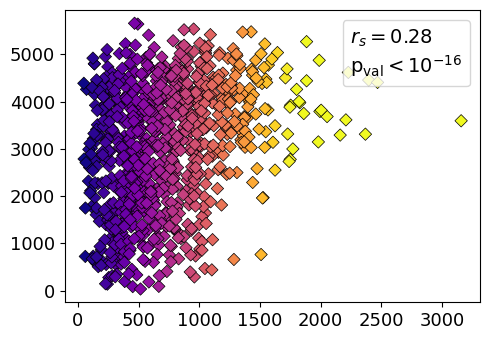

In [37]:
coly = 'eccentricity'
gidx = 85
colx = 'N_cyto_' + transcriptomes[gidx]
x,y = df[ [colx , coly] ].T.values
vmax = utils.maximum_qq_size(x, alpha=0.25, iqr_factor=1.5)
vmin = utils.minimum_qq_size(x, alpha=0.25, iqr_factor=1.5)
#x[x > vmax] = vmax
#x[x < vmin] = vmin

fig, ax = plt.subplots(1, 1, figsize=(5,3.5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].scatter(x,y, c=x, marker=Ms[gidx], cmap=Cmap, edgecolor='black', linewidth=0.5, vmin=vmin, vmax=vmax,
              zorder=2, s=40, label=corr_labels[coly][colx])
ax[i].legend(fontsize=14, handlelength=0, handletextpad=0, loc='upper right', markerscale=0)

ax[i].tick_params(labelsize=13)
ax[i].set_aspect('auto', 'datalim')
fig.tight_layout()


In [39]:
coly = 'eccentricity'
for colx in df.columns[2:-4]:
#for gidx in Genes:
    #for colx in ['PCA{:02d}_{}'.format(x+1, transcriptomes[gidx]) for x in range(pca.shape[1])] + [bar+'_cyto_'+transcriptomes[gidx] for bar in ['N','rho']]:
    #for colx in ['PCA{:02d}_{}'.format(x+1, transcriptomes[gidx]) for x in range(pca.shape[1])]:
        #for coly in [bar+'_cyto_'+transcriptomes[gidx] for bar in ['N','rho']]:
            x,y = df[ [colx , coly] ].T.values
            vmax = utils.maximum_qq_size(x, alpha=0.25, iqr_factor=1.5)
            vmin = utils.minimum_qq_size(x, alpha=0.25, iqr_factor=1.5)
            
            fig, ax = plt.subplots(1, 1, figsize=(5,3.5), sharex=True, sharey=True)
            ax = np.atleast_1d(ax).ravel(); i = 0
            
            ax[i].scatter(x,y, c=x, marker='o', cmap=Cmap, edgecolor='black', linewidth=0.5, vmin=vmin, vmax=vmax,
                          zorder=2, s=40, label=corr_labels[coly][colx])
            ax[i].legend(fontsize=14, handlelength=0, handletextpad=0, loc='upper right', markerscale=0)

            
            ax[i].tick_params(labelsize=13)
            ax[i].set_aspect('auto', 'datalim')
            
            filename = dst + '{}level_{}_s{}_bw{}_S{}_'.format(*nameparams[:-3]) + cell_mask + '_' + coly + '_' + colx
            print(filename)
            fig.savefig(filename + '.pdf', bbox_inches='tight',transparent=False, pad_inches=0);
            plt.close()

/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_all_eccentricity_cyto_area
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_all_eccentricity_cyto_volume
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_all_eccentricity_eccentricity
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_all_eccentricity_PCA01_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_all_eccentricity_PCA02_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_all_eccentricity_PCA01_GLYMA_05G092200
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_all_eccentricity_PCA02_GLYMA_05G092200
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_all_eccentricity_N_cyto_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_all_eccentricity_rho_cyto_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_